# GA Capstone - Sortify

##### Aziz Maredia | DSIR-1019 | 01.27.21

### Importing Libraries/Packages and Dataframes

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

In [2]:
tracks = pd.read_csv('.././datasets/combined_tracks.csv')

In [3]:
tracks.shape

(1542, 51)

In [4]:
tracks.head()

,track,artist,track_id,data_type,popularity_artist,popularity_song,danceability,energy,loudness,speechiness,...,r&b,rap,reggae,rock,romance,soul,south_american,swing,techno,trance
0,JustYourSoul - Tchami Remix,Valentino Khan,5NJi42d7VDo8KPVksb7dS8,user_library,64,48.0,0.749,0.846,-3.441,0.0932,...,0,1,0,0,0,0,0,0,0,0
1,Moving Men,Myd,3y4I9VECfNbDXYN2bXh9hV,user_library,58,59.0,0.815,0.661,-8.208,0.0996,...,0,0,0,0,1,0,0,0,0,0
2,Sonate Pacifique,L'Impératrice,49PyCCLOdJi0jHkGyyY2vv,user_library,63,62.0,0.558,0.538,-8.853,0.0327,...,0,0,0,0,1,1,0,0,0,0
3,Casio,Jungle,44ZKnfWEkp7wPs035j4Tua,user_library,66,66.0,0.816,0.492,-7.464,0.0752,...,1,0,0,0,0,1,0,0,0,0
4,"Music Is My Hot, Hot Sex",CSS,5hzBRLhHC29XTml7gEEK6o,user_library,46,0.0,0.742,0.723,-5.620,0.0441,...,0,0,0,0,0,0,0,0,0,0


### Function to Clean Data

In [5]:
def clean_data(df):
    
    # bringing the following variables down to a 0-1 scale
    df['popularity_song'] = df['popularity_song'] / 100 # currently on 0-100 scale
    df['popularity_artist'] = df['popularity_artist'] / 100 # currently on 0-100 scale
    df['loudness'] = (df['loudness'] / 60) * -1 # currently on -60-0 scale
    
    # tempo is not on a scale so using a minmax scalar to bring it down to a 0-1 scale
    mms = MinMaxScaler()
    df[['tempo']] = mms.fit_transform(df[['tempo']])
    
    # only need year so removing day and month from release date, then turning it into a
    # categorical variable with values corresponding with the decade the track was released
    
    df['release_date'] = [int(i[:4]) for i in df['release_date']]
    new_dates = []
    
    for date in df['release_date']:
        if date < 1950:
            new_dates.append('Pre_50s')
        elif date >= 1950 and date < 1960:
            new_dates.append('50s')
        elif date >= 1960 and date < 1970:
            new_dates.append('60s')
        elif date >= 1970 and date < 1980:
            new_dates.append('70s')
        elif date >= 1980 and date < 1990:
            new_dates.append('80s')
        elif date >= 1990 and date < 2000:
            new_dates.append('90s')
        elif date >= 2000 and date < 2010:
            new_dates.append('2000s')
        elif date >= 2010:
            new_dates.append('Post_2010s')
        else:
            new_dates.append('Date not available') 
    
    df['release_date'] = new_dates
    
    # converting categorical columns into dummy variables
    df = pd.get_dummies(df, columns = ['key', 'release_date', 'time_signature'])
    
    return df

In [6]:
combined = clean_data(tracks)
combined.shape

(1542, 70)

In [7]:
combined.head()

,track,artist,track_id,data_type,popularity_artist,popularity_song,danceability,energy,loudness,speechiness,...,release_date_2000s,release_date_60s,release_date_70s,release_date_80s,release_date_90s,release_date_Post_2010s,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,JustYourSoul - Tchami Remix,Valentino Khan,5NJi42d7VDo8KPVksb7dS8,user_library,0.64,0.48,0.749,0.846,0.057350,0.0932,...,0,0,0,0,0,1,0,0,1,0
1,Moving Men,Myd,3y4I9VECfNbDXYN2bXh9hV,user_library,0.58,0.59,0.815,0.661,0.136800,0.0996,...,0,0,0,0,0,1,0,1,0,0
2,Sonate Pacifique,L'Impératrice,49PyCCLOdJi0jHkGyyY2vv,user_library,0.63,0.62,0.558,0.538,0.147550,0.0327,...,0,0,0,0,0,1,0,0,1,0
3,Casio,Jungle,44ZKnfWEkp7wPs035j4Tua,user_library,0.66,0.66,0.816,0.492,0.124400,0.0752,...,0,0,0,0,0,1,0,0,1,0
4,"Music Is My Hot, Hot Sex",CSS,5hzBRLhHC29XTml7gEEK6o,user_library,0.46,0.00,0.742,0.723,0.093667,0.0441,...,1,0,0,0,0,0,0,0,1,0


In [8]:
user_tracks_reg = combined.loc[combined['data_type'] == 'user_library', :].reset_index(drop = True)
album_tracks_reg = combined.loc[combined['data_type'] == 'album', :].reset_index(drop = True)

### Principal Component Analysis

Because our data contains 60+ features, I'm interested to see how dimensionality reduction with PCA would affect our modeling compared to using all of the features as is

In [9]:
X = combined.drop(columns = ['track', 'artist', 'track_id','data_type'])

In [10]:
tracks_pca = PCA().fit(X)

In [11]:
tracks_pca.explained_variance_ratio_

array([1.81542328e-01, 9.44341364e-02, 7.16083776e-02, 5.80651759e-02,
       3.59579735e-02, 3.26255915e-02, 3.09841679e-02, 2.71157000e-02,
       2.63790340e-02, 2.45244246e-02, 2.42098896e-02, 2.29130473e-02,
       2.26466003e-02, 2.19969449e-02, 2.18311884e-02, 2.06290868e-02,
       1.90928394e-02, 1.79106092e-02, 1.75864591e-02, 1.67667025e-02,
       1.58012098e-02, 1.48964893e-02, 1.45872453e-02, 1.36109807e-02,
       1.26290540e-02, 1.15635101e-02, 1.02665715e-02, 9.67886220e-03,
       8.85131762e-03, 8.37991810e-03, 7.10416883e-03, 7.05839166e-03,
       6.58533515e-03, 6.25454879e-03, 5.79459469e-03, 5.35046540e-03,
       4.74599631e-03, 4.67679979e-03, 4.40183002e-03, 4.25721630e-03,
       4.07604516e-03, 3.37159629e-03, 3.10771056e-03, 2.98668089e-03,
       2.78422313e-03, 2.44588614e-03, 2.30798542e-03, 1.98340078e-03,
       1.85992873e-03, 1.41448492e-03, 1.28345790e-03, 1.09796186e-03,
       1.02115333e-03, 9.30042656e-04, 8.32939146e-04, 7.85248319e-04,
      

In [12]:
cumsum_array = np.cumsum(tracks_pca.explained_variance_ratio_)
cumsum_array

array([0.18154233, 0.27597646, 0.34758484, 0.40565002, 0.44160799,
       0.47423358, 0.50521775, 0.53233345, 0.55871249, 0.58323691,
       0.6074468 , 0.63035985, 0.65300645, 0.67500339, 0.69683458,
       0.71746367, 0.73655651, 0.75446712, 0.77205357, 0.78882028,
       0.80462149, 0.81951798, 0.83410522, 0.8477162 , 0.86034526,
       0.87190877, 0.88217534, 0.8918542 , 0.90070552, 0.90908544,
       0.9161896 , 0.923248  , 0.92983333, 0.93608788, 0.94188248,
       0.94723294, 0.95197894, 0.95665574, 0.96105757, 0.96531478,
       0.96939083, 0.97276242, 0.97587013, 0.97885682, 0.98164104,
       0.98408693, 0.98639491, 0.98837831, 0.99023824, 0.99165272,
       0.99293618, 0.99403414, 0.9950553 , 0.99598534, 0.99681828,
       0.99760353, 0.99827921, 0.99889209, 0.99920324, 0.99950096,
       0.99969615, 0.99985903, 1.        , 1.        , 1.        ,
       1.        ])

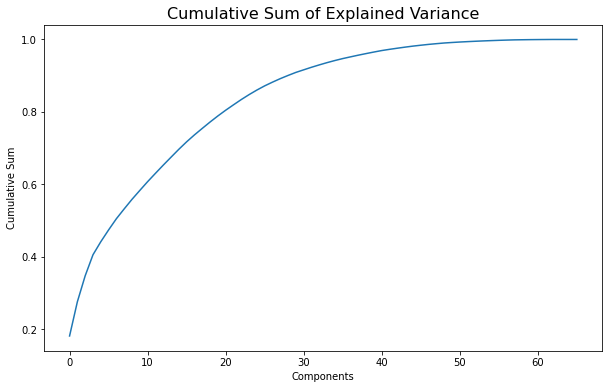

In [13]:
cumsum_df = pd.DataFrame(cumsum_array)

plt.figure(figsize = (10,6))

sns.lineplot(x = cumsum_df.index, y = cumsum_df[0]);

plt.xlabel('Components');
plt.ylabel('Cumulative Sum');
plt.title('Cumulative Sum of Explained Variance', fontsize = 16);

From the graph above we can see that our explained variance has diminishing returns/increase as we increase our number of components. Unfortunately, there isn't a method to deteremine the optimal number of components. For the sake of this analysis, I'm going to build a function that sets the number of components to the index of the first number where the cumulative sum increase by < 0.025.

In [14]:
def find_optimal_components(array):

    for i in enumerate(array[:len(array)-1]):
        diff = array[i[0] + 1] - i[1]
        if diff < 0.025:
            return i[0]
    
    return 8
    
find_optimal_components(cumsum_array)

8

In [15]:
pca = PCA(n_components = find_optimal_components(cumsum_array), random_state = 42)

combined_pca = pd.DataFrame(pca.fit_transform(X))
combined_pca = pd.concat([combined[['track', 'artist', 'track_id', 'data_type']], combined_pca], axis = 1)

user_tracks_pca = combined_pca.loc[combined_pca['data_type'] == 'user_library', :].reset_index(drop = True)
album_tracks_pca = combined_pca.loc[combined_pca['data_type'] == 'album', :].reset_index(drop = True)

In [16]:
user_tracks_pca.head()

,track,artist,track_id,data_type,0,1,2,3,4,5,6,7
0,JustYourSoul - Tchami Remix,Valentino Khan,5NJi42d7VDo8KPVksb7dS8,user_library,0.652642,-0.276648,-0.151994,-1.169888,-0.326094,-0.287370,0.512668,0.005565
1,Moving Men,Myd,3y4I9VECfNbDXYN2bXh9hV,user_library,0.342427,0.301863,0.421005,-0.069680,0.030846,-0.026948,-0.959429,-0.120693
2,Sonate Pacifique,L'Impératrice,49PyCCLOdJi0jHkGyyY2vv,user_library,-0.002135,0.488963,0.532549,0.348137,0.299269,-0.187829,-0.683467,-0.318521
3,Casio,Jungle,44ZKnfWEkp7wPs035j4Tua,user_library,-0.192306,0.554224,-0.584260,0.673738,0.794599,0.075141,-0.077608,0.181578
4,"Music Is My Hot, Hot Sex",CSS,5hzBRLhHC29XTml7gEEK6o,user_library,0.523293,0.454843,-0.245563,0.511041,-1.061059,0.187018,0.488037,0.643510


In [17]:
album_tracks_pca.head()

,track,artist,track_id,data_type,0,1,2,3,4,5,6,7
0,Beautiful Trip,Kid Cudi,4IIuCotvqijraSdnVLaFnM,album,-0.972820,-0.325843,-0.881435,0.048726,-0.242991,-0.150622,-0.164791,-0.225950
1,Tequila Shots,Kid Cudi,30KctD1WsHKTIYczXjip5a,album,-0.962903,-0.413141,-0.736288,0.085140,-0.222196,0.001046,-0.051066,0.236802
2,Another Day,Kid Cudi,6myUpr3GDR80Dg3zqNTmmG,album,-0.967243,-0.407851,-0.722297,0.042125,-0.144409,-0.039664,-0.105532,0.038616
3,She Knows This,Kid Cudi,1xzUQMiCoY5pdego0pHMeV,album,-0.958183,-0.408124,-0.735123,0.026436,-0.192800,-0.035678,-0.195416,0.327336
4,Dive,Kid Cudi,7Hc3YL8oDiAzbiAW32KXrw,album,-0.982440,-0.375580,-0.691379,0.031276,-0.181992,-0.106253,-0.113809,0.230019


### Exporting/Saving Dataframes for Modeling

In [18]:
# regular data
user_tracks_reg.to_csv('.././datasets/user_tracks_reg.csv', index = False)
album_tracks_reg.to_csv('.././datasets/album_tracks_reg.csv', index = False)

#pca data
user_tracks_pca.to_csv('.././datasets/user_tracks_pca.csv', index = False)
album_tracks_pca.to_csv('.././datasets/album_tracks_pca.csv', index = False)